<a href="https://colab.research.google.com/github/brunograssano/TP-Organizacion-de-datos/blob/main/TP_Datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Practico: Analisis Exploratorio - Organizacion de Datos

## Introduccion

Explicacion

## Objetivos

El objetivo del notebook es:
*   Entender los datos
*   Ver como los datos se relacionan entre si
*   Poder sacar alguna conclusión o descubrir un patrón a partir de estos
*   Indicar cuáles son los factores más importantes que determinan si un usuario va a ir al cine a ver Frozen 4 o no.




## Configuraciones Iniciales

Primero cargamos las bibliotecas que se van a ir usando a lo largo del trabajo, y realizamos la configuracion para los graficos que armemos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Carga y limpieza del set de datos

Cargamos ambos Datasets y vemos de dejarlos listos para comenzar el trabajo

In [2]:
usuario_volveria_df = pd.read_csv('tp-2020-2c-train-cols1.csv')
usuario_volveria_df.head()

,id_usuario,volveria
0,117,0
1,658,0
2,794,0
3,455,0
4,173,1


In [3]:
info_fiumark_df = pd.read_csv('tp-2020-2c-train-cols2.csv')
info_fiumark_df.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señor Camilo Pedro,117,hombre,73.5,0,0,59258;,1,NaN,fiumark_quilmes
1,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,586:6;,2,NaN,fiumark_quilmes
2,normal,Señor Antonio Federico,794,hombre,NaN,0,0,"RE""39822",3,NaN,fiumark_chacarita
3,4d,Señor Osvaldo Aureliano,455,hombre,NaN,0,0,"C17""4:39",1,NaN,fiumark_palermo
4,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,569964,2,NaN,fiumark_palermo


Analizamos primero los tipos de datos que tienen ambos dataframes con el objetivo de poder convertirlos a otros que puedan llegar a ser mas utiles.

In [4]:
usuario_volveria_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   id_usuario  801 non-null    int64
 1   volveria    801 non-null    int64
dtypes: int64(2)
memory usage: 12.6 KB


Notamos que la columna de 'volveria' es de tipo int64, cuando solamente tiene valores que pueden ser 0 o 1. Un mejor tipo de dato para este caso puede ser un int8. Esto permitiria ahorrar memoria. (Aunque en este caso no sean muchos datos)

In [5]:
usuario_volveria_df['volveria'] = usuario_volveria_df['volveria'].astype(np.int8)

Observamos en la informacion del dataframe que hay 801 registros y que para este caso no se encuentran valores nulos

Veamos ahora el otro dataframe. Este dataframe contiene la informacion respecto de las personas. 

In [6]:
info_fiumark_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tipo_de_sala   801 non-null    object 
 1   nombre         801 non-null    object 
 2   id_usuario     801 non-null    int64  
 3   genero         801 non-null    object 
 4   edad           641 non-null    float64
 5   amigos         801 non-null    int64  
 6   parientes      801 non-null    int64  
 7   id_ticket      801 non-null    object 
 8   precio_ticket  801 non-null    int64  
 9   fila           177 non-null    object 
 10  nombre_sede    799 non-null    object 
dtypes: float64(1), int64(4), object(6)
memory usage: 69.0+ KB


Notamos una gran cantidad de valores nulos en la columna "fila" y algunos en "edad" y "nombre_sede". Como las columnas que tienen los valores nulos pueden llegar a ser relevantes para el analisis, siendo este el caso de las columnas "fila" y "edad" decidimos crear la categoria "No responde" para el caso de "fila".

In [7]:
info_fiumark_df['fila'].fillna("No responde",inplace=True)

Ahora vemos la cantidad de valores unicos para las columnas de tipo objeto, para poder determinar a cuales les corresponderia tener un tipo categorico.

In [8]:
info_fiumark_df.select_dtypes(include=['object']).nunique()

tipo_de_sala      3
nombre          801
genero            2
id_ticket       635
fila              3
nombre_sede       3
dtype: int64

In [9]:
info_fiumark_df["tipo_de_sala"] = info_fiumark_df["tipo_de_sala"].astype("category")
info_fiumark_df["genero"] = info_fiumark_df["genero"].astype("category")
info_fiumark_df["nombre_sede"] = info_fiumark_df["nombre_sede"].astype("category")
info_fiumark_df["fila"] = info_fiumark_df["fila"].astype("category")


Otra cosa que observamos que las edades estan en formato de float, lo cual nos resulto llamativo, por lo que decidimos cortar los valores, llevandolos al piso.

In [10]:
info_fiumark_df['edad'] = info_fiumark_df['edad'].apply(np.floor) 
#info_fiumark_df['edad'] = info_fiumark_df['edad'].astype(np.int) # VER QUE HACEMOS CON LOS VALORES NULOS, PREGUNTAR SI ES VALIDO TOMAR EL 3er CUANTIL POR LA EDAD

Tambien observamos que entre los datos que nos fueron entregados se encuentra el codigo de ticket: "id_ticket". Consideramos
que la informacion en ella es irrelevante para nuestros propositos y por lo tanto la eliminamos. Esta decision se debe a que parece que el codigo del ticket tiene forma de ser generada de forma aleatoria y no da la impresion de estar relacionada con la variable de interes para el analisis.

In [11]:
info_fiumark_df.drop(columns='id_ticket',inplace=True)

Habiendo hecho esos cambios, finalmente nos queda el dataframe de la siguiente forma. En el proceso se redujo el uso de memoria, pasando de 69.0KB a 41.2KB.

In [12]:
info_fiumark_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   tipo_de_sala   801 non-null    category
 1   nombre         801 non-null    object  
 2   id_usuario     801 non-null    int64   
 3   genero         801 non-null    category
 4   edad           641 non-null    float64 
 5   amigos         801 non-null    int64   
 6   parientes      801 non-null    int64   
 7   precio_ticket  801 non-null    int64   
 8   fila           801 non-null    category
 9   nombre_sede    799 non-null    category
dtypes: category(4), float64(1), int64(4), object(1)
memory usage: 41.2+ KB


In [13]:
info_fiumark_df.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,precio_ticket,fila,nombre_sede
0,4d,Señor Camilo Pedro,117,hombre,73.0,0,0,1,No responde,fiumark_quilmes
1,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,2,No responde,fiumark_quilmes
2,normal,Señor Antonio Federico,794,hombre,NaN,0,0,3,No responde,fiumark_chacarita
3,4d,Señor Osvaldo Aureliano,455,hombre,NaN,0,0,1,No responde,fiumark_palermo
4,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,2,No responde,fiumark_palermo


Por ultimo, dejamos unidos ambos dataframes.

In [14]:
info_fiumark_df = info_fiumark_df.merge(usuario_volveria_df,on='id_usuario')
info_fiumark_df.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,precio_ticket,fila,nombre_sede,volveria
0,4d,Señor Camilo Pedro,117,hombre,73.0,0,0,1,No responde,fiumark_quilmes,0
1,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,2,No responde,fiumark_quilmes,0
2,normal,Señor Antonio Federico,794,hombre,NaN,0,0,3,No responde,fiumark_chacarita,0
3,4d,Señor Osvaldo Aureliano,455,hombre,NaN,0,0,1,No responde,fiumark_palermo,0
4,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,2,No responde,fiumark_palermo,1


In [15]:
#Explicar qué conclusiones se pueden llegar a partir de analizar los datos recolectados. 
#La empresa quiere saber cómo entender cada uno de los datos, cómo se relacionan entre sí
#Si se puede sacar alguna conclusión o descubrir un patrón a partir de estos. 
#Adicionalmente quieren saber cuáles son los factores más importantes que determinan si un usuario va a ir al cine a ver Frozen 4 o no.

## Analisis exploratorio

Empecemos el analisis haciendonos algunas preguntas sencillas.  
* ¿Es el genero una variable determinante a la hora de decidir ver la secuela?
*
* ¿Afecta en algo el ir a disitintos tipos de sala la decision?
*
*
*
*
*

In [16]:
#¿Cuáles fueron las preguntas que se plantearon inicialmente?
#¿Qué se hizo para responder a esas preguntas?
#De los gráficos y análisis hechos, ¿qué conclusiones se pueden sacar?
#A partir del trabajo en los anteriores puntos, ¿surgieron nuevas dudas? -> Volver al paso 2
#A partir de todo el análisis anterior, construir el código baseline que se va a usar para la primera ronda de campaña digital. Fundamentar el código basándose en las conclusiones de los anteriores puntos.

### ¿Cuanto afecta el genero a la hora de ir a ver la siguiente pelicula?

Vemos que proporcion de los hombres y mujeres que fueron a ver la pelicula volverian a ver la secuela. Esto se puede obtener de forma sencilla.

A priori esperamos que la proporcion de mujeres que deciden ir a ver la secuela sea mucho mayor que la de los hombres que fueron a ver la pelicula.

In [17]:
porcentaje_generos_volveria = info_fiumark_df.groupby(by='genero')['volveria'].agg('mean')
porcentaje_generos_volveria.round(2)

genero
hombre    0.18
mujer     0.74
Name: volveria, dtype: float64

Habiendo hecho el calculo, en los numeros se ve claramente lo esperado.

Text(0.5, 0, 'Genero')

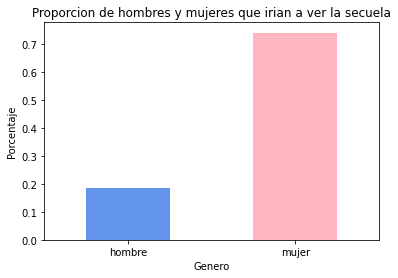

In [18]:
porcentaje_generos_volveria.plot(kind = 'bar',rot = 0, color = ['cornflowerblue','lightpink'], title = 'Proporcion de hombres y mujeres que irian a ver la secuela')
ax = plt.gca()
ax.set_ylabel("Porcentaje")
ax.set_xlabel("Genero")

### ¿Afecta en algo el ir a disitintos tipos de sala la decision?

Veamos ahora si la decision de ir a un tipo de sala mejor determina si se vuelve a ver la secuela. 

Para empezar veamos cuales hay.

In [19]:
cantidad_salas = info_fiumark_df['tipo_de_sala'].value_counts()
cantidad_salas

4d        447
normal    187
3d        167
Name: tipo_de_sala, dtype: int64

Sorprendentemente, la mayoria de la gente que fue a ver la pelicula decidio ir a las salas especiales (4D y 3D). Esto se puede deber a que se busca tener una experiencia unica al momento de ir al cine. Esto lo mostramos en el siguiente grafico con respecto a la cantidad total de gente que fue.

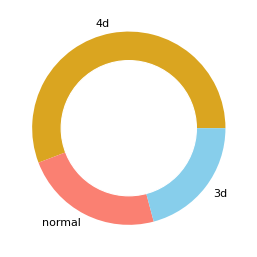

In [20]:
circulo_centro=plt.Circle( (0,0), 0.7, color='white')
plt.figure(dpi=80)
plt.pie(cantidad_salas.values, labels=cantidad_salas.index.to_list(), colors=['goldenrod','salmon','skyblue'])
p=plt.gcf()
p.gca().add_artist(circulo_centro)
plt.show()

Busquemos ahora si hay relacion con la secuela.


In [21]:
porcentaje_volveria_salas = info_fiumark_df.groupby(by='tipo_de_sala')['volveria'].agg('mean').round(2)
porcentaje_volveria_salas

tipo_de_sala
3d        0.49
4d        0.23
normal    0.64
Name: volveria, dtype: float64

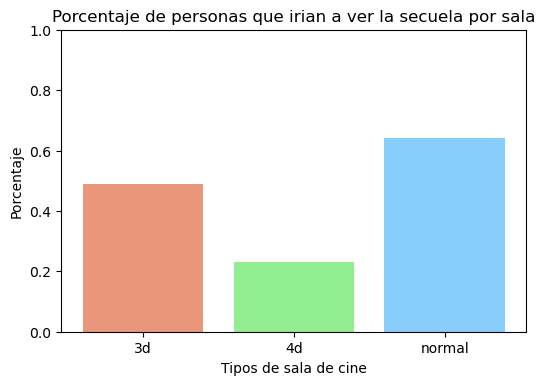

In [22]:
plt.figure(dpi=100)
plt.bar(porcentaje_volveria_salas.index, porcentaje_volveria_salas.values, color = ['darksalmon','lightgreen','lightskyblue'])
plt.ylabel("Porcentaje")
plt.xlabel("Tipos de sala de cine")
plt.ylim(0, 1)
plt.title('Porcentaje de personas que irian a ver la secuela por sala')
plt.show()

Observando los resultados, notamos que una gran cantidad de la gente que fue a la sala 4D, decidio que no volveria a ver la secuela (cercano al 80%). Uno de los motivos por los que esto puede llegar a ser es que las personas que deciden ir a esta sala esperan tener una gran experiencia debido a los efectos que agrega la sala, ya sean movimientos, niebla, lluvia, u otros efectos del estilo, los cuales pueden no estar siendo aprovechados del todo durante la proyeccion de la pelicula.


Con respecto a la sala 3D, podemos decir que no nos estaria aportando mucho por si sola. Esto se debe a que la mitad de la gente que decide ir a esta sala volveria a la secuela, mientras que el resto no. Resultando como si fuera el lanzamiento de una moneda.

Por ultimo, de la sala normal podemos decir que cerca del 64% dijo que vovleria a la secuela. Que una mayor cantidad diga en esta sala que volveria puede deberse a que ya conocieran de antes la serie de peliculas Frozen.

### ¿Cuanto afecta el genero a la hora de ir a ver la siguiente pelicula?

Veamos primero que proporcion de las personas que fueron a ver la pelicula son hombres y que proporcion mujeres:

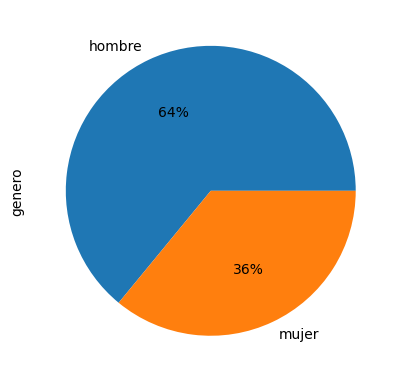

In [24]:
plt.figure(figsize=(6.4, 4.8), dpi=100)
genero = info_fiumark_df['genero'].value_counts().sort_index().plot(kind='pie', autopct='%1.0f%%')
plt.show()

Observamos que casi dos tercios de las personas que fueron a ver la pelicula son hombres y un tercio mujeres.
Si bien a primera vista esto parece indicar que la pelicula atrae mas a hombres que a mujeres debemos analizar si
estos hombres y mujeres disfrutaron la pelicula lo suficiente como para volver a verla.

Buscamos ver ahora que proporcion de los hombres y mujeres que fueron a ver la pelicula volverian a ver la secuela. Esto se puede obtener de forma sencilla.

A priori esperamos que la proporcion de mujeres que deciden ir a ver la secuela sea mucho mayor que la de los hombres que fueron a ver la pelicula.

In [25]:
porcentaje_generos_volveria = info_fiumark_df.groupby(by='genero')['volveria'].agg('mean')
porcentaje_generos_volveria.round(2)

genero
hombre    0.18
mujer     0.74
Name: volveria, dtype: float64

Habiendo hecho el calculo, en los numeros se ve claramente lo esperado.

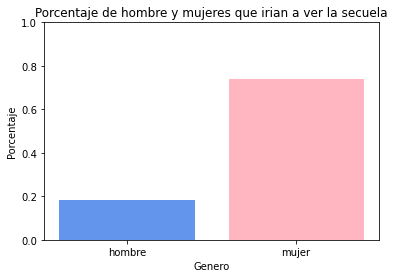

In [26]:
porcentaje_genero_volveria = info_fiumark_df.groupby(by='genero')['volveria'].agg('mean')
plt.bar(porcentaje_genero_volveria.index, porcentaje_genero_volveria.values, color = ['cornflowerblue','lightpink'])
plt.ylabel("Porcentaje")
plt.xlabel("Genero")
plt.ylim(0, 1)
plt.title('Porcentaje de hombre y mujeres que irian a ver la secuela')
plt.show()

El grafico nos dice que del total de mujeres que fue a ver la pelicula un 74% de ellas volveria a ver la secuela. Mientras que solo el 18% de los hombres consideraron que la pelicula disfruto la pelicula lo suficiente como para querer ir a ver la secuela.

Estas observaciones nos hicieron preguntarnos ¿Por que hubo tantos hombres fueron incialmente a ver la pelicula? Nuestras hipotesis son que pueden ser padres que llevaron a sus hijos a ver la pelicula.

Para responder esta pregunta buscamos primero ver la distribucion de las edades de los hombres y las mujeres, para hello realizamos un boxplot.

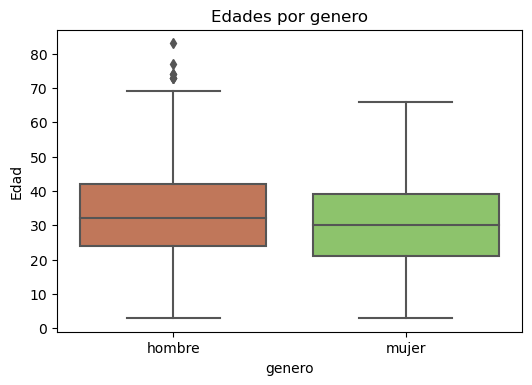

In [27]:
plt.figure(dpi=100)
plt.title("Edades por genero")
sns.boxplot(
    data=info_fiumark_df[['genero','edad']],
    y='edad',
    x='genero',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Edad")
plt.xticks([False, True])
plt.show()